In [136]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import keras
#from keras.models import Sequential, load_model
import shelve
import h5py
import math
import pandas as pd
import dashi as d
import scipy

In [194]:
#basepath = '/mnt/lfs3/user/jstettner/DeepIce/trainData/testDiffuseMini/2017-08-26-06-57-03/'
#basepath= '/data/user/jstettner/DeepIce/trainData/testDiffuseHex/2017-08-26-06-56-50/'
basepath = '/data/user/jstettner/DeepIce/trainData/testDiffuseHexDeep/2017-08-26-14-40-57/'
#RECO = "DeepIce_testMini"
#RECO = "DeepIce_testHex" 
RECO = "DeepIce_HexDeeper"

Nbins = 30
plot_data = pd.DataFrame(np.load(os.path.join(basepath, 'test_res.npy')))
xbins = np.linspace(2, 8, Nbins)
ybins = np.linspace(2, 8, Nbins)
resolution=[]
binmids_x = [(xbins[i+1]+xbins[i])/2 for i in range(len(xbins)-1)]
binmids_y = [(ybins[i+1]+ybins[i])/2 for i in range(len(ybins)-1)]

In [195]:
E_target = np.log10(plot_data['energy_truth'].values)
E_predicted_temp = plot_data['energy'].values
E_predicted = E_predicted_temp.copy()
E_predicted[E_predicted_temp<=0.] = np.nan
E_muEx = np.log10(plot_data['muex_truth'].values)

In [198]:
# read the loss logger and correct for the added epochs by just counting them
losses = np.genfromtxt(basepath+"loss_logger.csv", delimiter = ",", names=["epoch", "acc", "loss", "val_acc", "val_loss"], skip_header=1)

print losses["epoch"]
losses["epoch"] = np.array(range(len(losses["epoch"])))+1.
print losses["epoch"]

0.0


TypeError: len() of unsized object

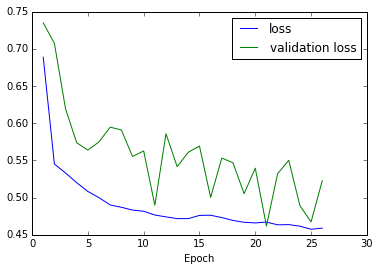

In [184]:
plt.plot(losses["epoch"], losses["loss"], label="loss")
plt.plot(losses["epoch"], losses["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("Epoch")

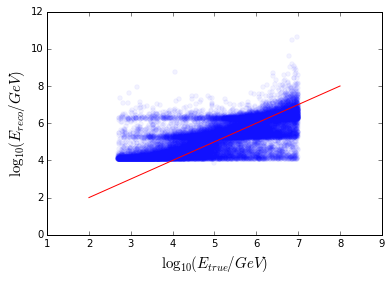

In [200]:
fig, ax= plt.subplots()
ax.scatter(x, y, color='blue', alpha= 0.05)
ax.plot(xbins, xbins, color='red')
ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$', size=15)
ax.set_ylabel(r'$\log_{10}(E_{reco}/GeV)$', size=15)
#ax.set_xlim(xbins[0],xbins[-1])
#ax.set_ylim(ybins[0],ybins[-1])
plt.savefig('plots/{}_scatter.png'.format(RECO))#, dpi=300)
plt.show()

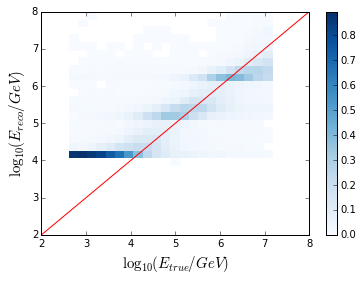

In [201]:
H, xedges, yedges = np.histogram2d(x,
                                   y, 
                                   bins=(xbins, ybins))
H = np.array([np.array(i)/np.sum(i) if np.sum(i)!= 0 else np.zeros(len(i)) for i in H ])
H = H.T  # Let each row list bins with common y range.
fig, ax = plt.subplots()
X, Y = np.meshgrid(xedges, yedges)
ax.plot(xbins,
        xbins,
        color='red')

plot_H = np.ma.array(H)
plot_H.mask = (plot_H == 0) | (plot_H>1.0)
cbar = ax.pcolormesh(X, Y, plot_H, cmap=plt.get_cmap('Blues'))
plt.colorbar(cbar)
ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$', size=15)
ax.set_ylabel(r'$\log_{10}(E_{reco}/GeV)$', size=15)
#ax.set_ylim(1.5,7)
#ax.set_xlim(1.5,7)
plt.savefig('plots/{}_PDF.png'.format(RECO))#, dpi=300)
plt.show()


In [187]:
#H.T

In [202]:
def energyResolutionGary(predicted, target, weights, Ebins):
    #https://arxiv.org/pdf/1311.4767.pdf
    e_reco_bins = Ebins                                                                                                                          
    e_true_bins = Ebins                                                                                                 
    h_pred = d.factory.hist2d((predicted,target), bins=(e_reco_bins, e_true_bins), weights=weights)                                                                
    ffunc = lambda x, loc, scale, norm : norm*scipy.stats.norm.pdf(x,loc,scale)                                                                                 
    stds_per_energy = []
    for i in xrange(h_pred.bincontent.shape[1]):
        h_pred = d.factory.hist2d((predicted,target), 
                                  bins=(e_reco_bins,e_true_bins),
                                  weights=np.ones(len(target)))                                                                   
        h_slice = h_pred[:,i]                                                                                                                                   
        h_pred.bincontent = h_pred.bincontent * h_slice.bincontent[:,np.newaxis]                                                                                 
        hs = h_pred.bincontent.sum(axis=0)                                                                                                                      
        if hs.sum() != 0:
            hs = hs / hs.sum()                                                                                                                                  
        nan_mask = ~np.isnan(hs)                                                                                                                                 
        ppar, pcov = scipy.optimize.curve_fit(ffunc,
                                              h_pred.bincenters[1][nan_mask],
                                              hs[nan_mask],
                                              p0=[h_slice.bincenters[i],0.2,1])
        stds_per_energy.append(ppar[1])                                                                                                                         
    return h_pred.bincenters[1], stds_per_energy 

In [203]:
E_true, E_res_gary = energyResolutionGary(E_predicted, E_target, weights=np.ones(np.shape(E_target)), Ebins=xbins)           
E_true, E_res_gary_muEx = energyResolutionGary(E_muEx, E_target , weights=np.ones(np.shape(E_muEx)), Ebins=xbins)           

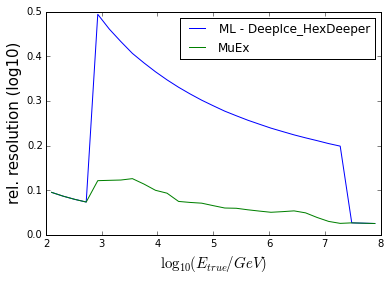

In [205]:
plt.plot(E_true, E_res_gary/E_true, label='ML - {}'.format(RECO))
plt.plot(E_true, E_res_gary_muEx/E_true, label='MuEx')
plt.legend()
plt.xlabel(r'$\log_{10}(E_{true}/GeV)$', size=15)
plt.ylabel(r'rel. resolution (log10)', size=15)
#plt.xlim(2,6)

In [95]:
temp_resolution = []
for i, binmid in enumerate(binmids_x):
    average = np.average(binmids_y, weights=H.T[i])
    std = math.sqrt(np.average((binmids_y-average)**2, weights=H.T[i]))
    temp_resolution.append(std/binmid)
resolution = temp_resolution

ZeroDivisionError: Weights sum to zero, can't be normalized

# Execute after all Recos have been appended

/cvmfs/icecube.opensciencegrid.org/py2-v3_early_access/RHEL_6_x86_64/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


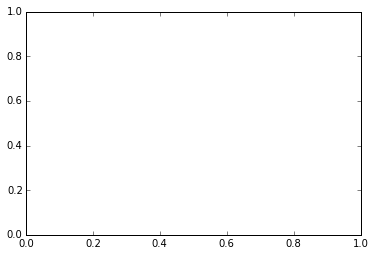

In [90]:
fig, ax= plt.subplots()
for reco in resolution:
    ax.plot(binmids_x, reco[1], label=reco[0])
    ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$')
    ax.set_ylabel(r'Resolution/\%')
plt.legend(loc='best')
plt.savefig('resolution.png')

In [91]:
#print resolution

# IceCube MuEx Reco

In [15]:
infiles = ['11029_00000-00999.h5','11029_01000-01999.h5','11029_02000-02999.h5','11029_03000-03999.h5']
xbins = np.linspace(2,7,30)
ybins = np.linspace(2,7,30)

In [16]:
H = np.zeros((29,29))
for infile in infiles:
    data = h5py.File('./training_data/{}'.format(infile))
    H_temp, _, _ = np.histogram2d(np.concatenate(np.log10(data['reco_vals'][:,0:1])), 
                                       np.concatenate(np.log10(data['reco_vals'][:,3:4])),
                                       bins=(xbins, ybins))
    H += H_temp
    

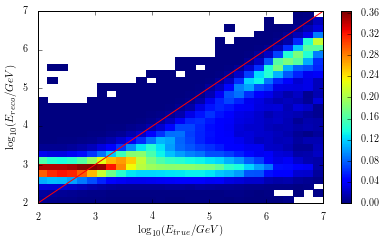

In [17]:
H=np.array([np.array(i)/np.sum(i) for i in H])
H = H.T  # Let each row list bins with common y range.
fig, ax = newfig(0.9)
X, Y = np.meshgrid(xbins, ybins)
ax.plot(np.linspace(2,7,10), np.linspace(2,7,10),color='red')
H= np.ma.array(H)
H.mask = H == 0
X, Y = np.meshgrid(xbins, ybins)
cbar = ax.pcolormesh(X, Y, H)
plt.colorbar(cbar)
ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$')
ax.set_ylabel(r'$\log_{10}(E_{reco}/GeV)$')
plt.savefig('muex.png')
plt.show()

In [187]:
test = [[] for i in range(2)]

In [191]:
test[1].extend([1,2])

In [192]:
print test

[[1, 2], [1, 2, 1, 2]]


In [469]:
a = []

In [474]:
a.append(([1,2],2))

In [475]:
print a

[(1, 2), (1, 2), ([1, 2], 2)]
